# Multi class prediction
We are following up on [part 1](./01_malaria_blood_cells.ipynb).

Most of this notebook is a copy of part 1. But a few things have changed too be able to predict multiple classes.

In this notebook we will introduce:
- one hot encoding
- softmax

In [1]:

import os

import cv2
import tensorflow as tf
from tomni import bbox_fitting_center
from random import shuffle
from matplotlib import pyplot as plt
import numpy as np 

# This is some code for when you only have 1 GPU in your computer.
# If you have multiple or none it will still work fine
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

N_EPOCHES = 20
IMAGE_DIM = 128

C:\Users\tomni\anaconda3\envs\tf_gpu_2_3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tomni\anaconda3\envs\tf_gpu_2_3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\tomni\anaconda3\envs\tf_gpu_2_3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Loading the data

Our malaria data set from part 1 does not have more then 2 classes so we will switch to a different dataset, namely the [Malignant Lymphoma classification dataset](https://www.kaggle.com/andrewmvd/malignant-lymphoma-classification).
I recomment to read the [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2911652/) for all the details but for us only 1 part is imported, it has 3 different classes to predict.

- CLL (chronic lymphocytic leukemia)
- FL (follicular lymphoma)
- MCL (mantle cell lymphoma)

Unlike the malaria dataset, the Lymphoma dataset is not balanced.
This means each class can have a different amount of images/data.
Later will learn how to work with unbalanced dataset but for now we will just load the first 113 (the number of image in the smallest class).
This makes our dataset balanced in a wastedfull way.


In [2]:
# Getting all the paths

data_location_cll=r"D:\data\Malignant_Lymphoma\CLL"
data_location_fl=r"D:\data\Malignant_Lymphoma\FL"
data_location_mcl=r"D:\data\Malignant_Lymphoma\MCL"

all_cll_paths = [os.path.join(data_location_cll, i) for i in os.listdir(data_location_cll) if i.endswith(".tif")]
all_fl_paths = [os.path.join(data_location_fl, i) for i in os.listdir(data_location_fl) if i.endswith(".tif")]
all_mcl_paths = [os.path.join(data_location_mcl, i) for i in os.listdir(data_location_mcl) if i.endswith(".tif")]

shuffle(all_cll_paths)
shuffle(all_fl_paths)
shuffle(all_mcl_paths)

In [3]:
def load_and_preprocess(path):
    img = cv2.imread(path)
    img = bbox_fitting_center(img, (IMAGE_DIM, IMAGE_DIM))
    return img

all_cll_images = [load_and_preprocess(path) for path in all_cll_paths[:113]]
all_fl_images = [load_and_preprocess(path) for path in all_fl_paths[:113]]
all_mcl_images = [load_and_preprocess(path) for path in all_mcl_paths[:113]]

## Let's have a look at the data we are dealing with

We will vizualize 96 random images and its labels just to see what we are dealing with.
This is done to give an idea of how things look like, and can help us make descision later on.

In this dataset we can see that cutting out only the middle part of the image make that we loss alot data. Only if we could do something about it (foreshadowing to random cropping as data augmenation).

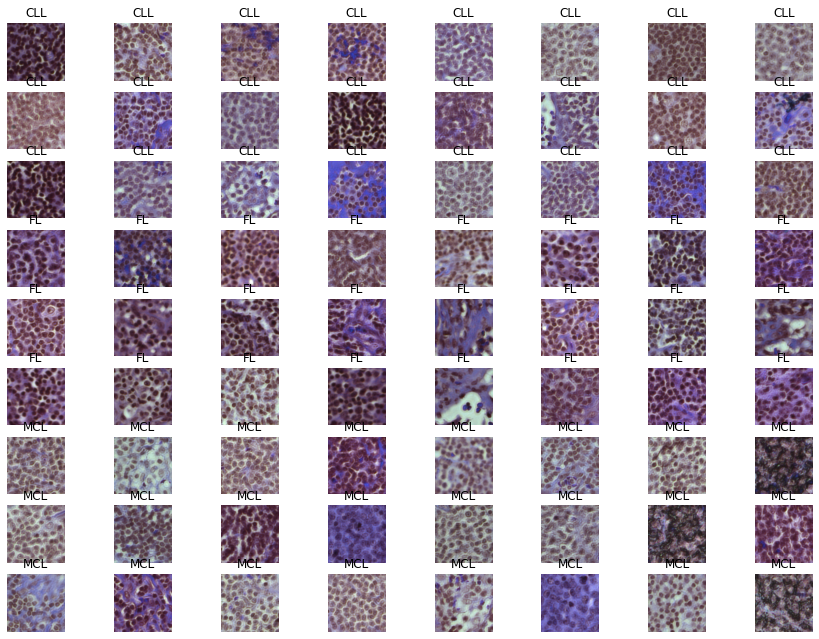

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15,15))
for i, image in enumerate(all_cll_images[:24]):
  ax = plt.subplot(12, 8, i + 1)
  plt.imshow(image)
  plt.title("CLL")
  plt.axis("off")

for i, image in enumerate(all_fl_images[:24]):
  ax = plt.subplot(12, 8, i + 25)
  plt.imshow(image)
  plt.title("FL")
  plt.axis("off")

for i, image in enumerate(all_mcl_images[:24]):
  ax = plt.subplot(12, 8, i + 49)
  plt.imshow(image)
  plt.title("MCL")
  plt.axis("off")

plt.show()

## Preparing data for training

The model still only can predict a number, not a class. So once again we assign numbers to our classes. cll becomes 0, fl becomes 1 and mcl becomes 2.

And here is where things become weird. Because if we leave it like this the model will think mcl = 2 * fl. That is, in technical terms, nonesense.
This means that the model will 'think' that if fl signal is very strong it becomes mcl.

Because this is not what we want we will use 1-hot-encoding.
- class 0: `[1, 0, 0]`
- class 1: `[0, 1, 0]`
- class 2: `[0, 0, 1]`

This makes the label 3 numbers long. The model will read a cll label as: it is 100% cll, 0% fl and 0% mcl.
This means the model will not only predict what is the correct label, but also what is NOT the correct label.

To make it even easier, tensorflow already has a function for us to do it!

In [5]:
x_list = all_cll_images + all_fl_images + all_mcl_images
y_list = [0] * len(all_cll_images) + [1] * len(all_fl_images) + [2] * len(all_mcl_images)

# we make the lists into numpy arrays because tensorflows doesn't like lists
x = np.array(x_list)
y_array = np.array(y_list)

# We encode the labels and say there are a total of 3 classes
y = tf.one_hot(y_array, 3)

## Getting the model
We wil use the same model as in part 1 but with 2 changes. 

We will have it output 3 value instate of 1.
This is done by changing the number of filter (first value) into 3.

And we changed the activation from sigmoid to softmax.
Softmax look a lot like a sigmoid but has an extra feature, normalize over the classes.
It will make sure that the sum of the three classes (CLL, FL, MCL) is always 1 for every image we give it.
And it makes sure each class is between 0 and 1.

Also I remove all the explaination.

In [6]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.models import Model

effienct_net_b0 = EfficientNetB0(include_top=False, weights=None, input_shape=(IMAGE_DIM, IMAGE_DIM, 3))
max_pool = MaxPooling2D((4, 4))(effienct_net_b0.output)
conv2d = Conv2D(3, (1, 1), activation="softmax")(max_pool)
flat = Flatten()(conv2d)

input_layer = effienct_net_b0.input
model = Model(input_layer, flat)

In [7]:
test_image = np.array([all_cll_images[0]])

p = model.predict(test_image)

print(p.shape)

(1, 3)


## Loss & optimalization

We keep the same optimizer, and the loss function. But we change the accuracy to categorical_accuracy. This is special metric that knows we have hot-encoded the data.


In [8]:
model.compile(
    optimizer="sgd", loss="mean_absolute_error", metrics=['categorical_accuracy'])

## Training the model

*technical part:*

If this goes really slow check if your GPU is used.
If not, try to fix it or be patient.


In [9]:
history = model.fit(
    x, y, epochs=100
)

Epoch 1/100
11/11 [==============================] - 10s 940ms/step - loss: 0.4585 - categorical_accuracy: 0.3156
Epoch 2/100
11/11 [==============================] - 7s 621ms/step - loss: 0.4453 - categorical_accuracy: 0.3451
Epoch 3/100
11/11 [==============================] - 7s 625ms/step - loss: 0.4332 - categorical_accuracy: 0.3658
Epoch 4/100
11/11 [==============================] - 7s 625ms/step - loss: 0.4349 - categorical_accuracy: 0.3510
Epoch 5/100
11/11 [==============================] - 7s 620ms/step - loss: 0.4295 - categorical_accuracy: 0.3982
Epoch 6/100
11/11 [==============================] - 7s 625ms/step - loss: 0.4360 - categorical_accuracy: 0.3658
Epoch 7/100
11/11 [==============================] - 7s 619ms/step - loss: 0.4397 - categorical_accuracy: 0.3481
Epoch 8/100
11/11 [==============================] - 7s 621ms/step - loss: 0.4464 - categorical_accuracy: 0.3510
Epoch 9/100
11/11 [==============================] - 7s 621ms/step - loss: 0.4496 - categorical

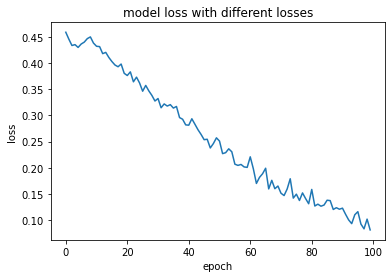

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss with different losses')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

# Results

Lets make some predictions. Because the output shape is now 3 long we will pick to the highest number using arg_max. This way we get our classes.

In [11]:
cll_predictions = model.predict(np.array(all_cll_images[:32]))
fl_predictions = model.predict(np.array(all_fl_images[:32]))
mcl_predictions = model.predict(np.array(all_mcl_images[:32]))

cll_classes = np.argmax(cll_predictions, axis=-1)
fl_classes = np.argmax(fl_predictions, axis=-1)
mcl_classes = np.argmax(mcl_predictions, axis=-1)

print("CLL", np.bincount(cll_classes))

print("FL",np.bincount(fl_classes))

print("MCL", np.bincount(mcl_classes))

CLL [32]
FL [ 0 32]
MCL [ 1  0 31]


# A different loss function

The mean absolute error could work but has a few times where is give weird results.
Lets say the model predicts 2 images at the same time, both are CLL (so `[1, 0, 0]`).
The model makes 2 predictions: `[[1, 0, 0], [0, 1, 0]]` and `[[0.5, 0.25, 0.25], [0.5, 0.25, 0.25]]`.
The mean absolute error would say both of these prediction have the same loss (are as good as each other).

The formula would look like this:
- nclass = number of classes
- nimage = number of images
- y = the correct label
- p = the predicted label

$mean absolute error = \sum_{i=0}^{nimage} |y_i - p_i$|

The problem is that increasing the prediction from 0.1 to 0.2 is seen as just as good as an option as increasing from 0.8 to 0.9.
To solve this we can use the $\log$ and a hot_encoding trick.

If we calculated the $\log(p)$ all the correct answers will get close 0 and incorrect predictions will go to $-\infty$.
But it will also effect the prediction that need to be $-\infty$, like the fl prediction in image that needs to be cll.
The solve this we use the zeros of label itself.

Be multipling a label (like [0, 1, 0]) with a prediction (like [0.2, 0.7, 0.1]) we get only the prediction of the label it should be ([0, 0.7, 0]).

If we combine these 2 ideas we get categorical crossentropy.

$categorical crossentropy = \sum_{j=0}^{nimage} y_j * \log(p_j)$

In [12]:
effienct_net_b0 = EfficientNetB0(include_top=False, weights=None, input_shape=(IMAGE_DIM, IMAGE_DIM, 3))
max_pool = MaxPooling2D((4, 4))(effienct_net_b0.output)
conv2d = Conv2D(3, (1, 1), activation="softmax")(max_pool)
flat = Flatten()(conv2d)

input_layer = effienct_net_b0.input

model2 = Model(input_layer, flat)

model2.compile(
    optimizer="sgd", loss="categorical_crossentropy", metrics=['categorical_accuracy'])

In [13]:
history2 = model2.fit(
    x, y, epochs=100
)

Epoch 1/100
11/11 [==============================] - 1s 98ms/step - loss: 2.1926 - categorical_accuracy: 0.3274
Epoch 2/100
11/11 [==============================] - 1s 93ms/step - loss: 2.4192 - categorical_accuracy: 0.3687
Epoch 3/100
11/11 [==============================] - 1s 93ms/step - loss: 1.8160 - categorical_accuracy: 0.3333
Epoch 4/100
11/11 [==============================] - 1s 95ms/step - loss: 1.7910 - categorical_accuracy: 0.3717
Epoch 5/100
11/11 [==============================] - 1s 93ms/step - loss: 2.0333 - categorical_accuracy: 0.3599
Epoch 6/100
11/11 [==============================] - 1s 93ms/step - loss: 1.5401 - categorical_accuracy: 0.4100
Epoch 7/100
11/11 [==============================] - 1s 93ms/step - loss: 1.7026 - categorical_accuracy: 0.4159
Epoch 8/100
11/11 [==============================] - 1s 94ms/step - loss: 1.5886 - categorical_accuracy: 0.4336
Epoch 9/100
11/11 [==============================] - 1s 94ms/step - loss: 1.5072 - categorical_accuracy:

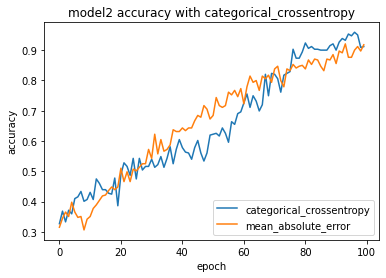

In [14]:
# summarize history for accuracy
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model2 accuracy with categorical_crossentropy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['categorical_crossentropy', 'mean_absolute_error'], loc='lower right')
plt.show()

In [15]:
cll_predictions2 = model2.predict(np.array(all_cll_images[:32]))
fl_predictions2 = model2.predict(np.array(all_fl_images[:32]))
mcl_predictions2 = model2.predict(np.array(all_mcl_images[:32]))

cll_classes2 = np.argmax(cll_predictions2, axis=-1)
fl_classes2 = np.argmax(fl_predictions2, axis=-1)
mcl_classes2 = np.argmax(mcl_predictions2, axis=-1)

print("CLL", np.bincount(cll_classes2))

print("FL",np.bincount(fl_classes2))

print("MCL", np.bincount(mcl_classes2))

CLL [32]
FL [ 0 32]
MCL [ 3  0 29]
